## About this notebook
主要采用五折

还可以尝试的点:

五折交叉均值融合 base  0.97709

单折     base   0.974

五折交叉验证,权重融合  0.9789

领域内数据进一步预训练

1.加中文数据集 用xlm-bert

2.精调warm_up    0.9794

4.dropout  0.9706

3.利用伪标签 

4.标签平滑    0.9790

5:添加印度语数据

6:五折交叉验证,平均融合  0.9814

7:五折交叉验证,权重融合  0.9789

8:单折,平均融合

9:单折,权重融合
 ,
10:长度 130 0.978, 192 0.976



五折交叉验证 base

单折     base     



In [1]:
import os
import jieba
import numpy as np 
import tensorflow_addons as tfa
from tensorflow_addons.optimizers import AdamW
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import copy
import random
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from string import digits, punctuation
import re
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from transformers import AutoModel
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
import transformers
from transformers import BertTokenizer,BertModel,BertConfig,BertForPreTraining
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
import pandas as pd
from gensim.models.word2vec import Word2VecKeyedVectors
AUTO = tf.data.experimental.AUTOTUNE

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
transformers.__version__

'2.11.0'

## Helper Functions

In [3]:
def seed_everything(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['PYTHONHASHSEED']=str(seed)
    random.seed(seed)


seed = 1024
seed_everything(seed)

In [4]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [5]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen     
    )
    
    return np.array(enc_di['input_ids'])

In [6]:
def build_model(transformer, max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(2, activation='softmax')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=5e-6), loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.01), metrics=['accuracy',tfa.metrics.F1Score(num_classes=2,average='weighted')])
    
    return model

## TPU Configs

In [7]:
# Detect hardware, return appropriate distribution strategy
#调用kaggle上的tpu必要代码
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [8]:
AUTO = tf.data.experimental.AUTOTUNE

# 五折交叉验证
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)#五折交叉验证
# Configuration
EPOCHS = 12
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
MAX_LEN = 140
use_external1 = False
use_external2 = True
use_pseudo = True
use_valid = True
DISPLAY_PLOT = True
# MODEL = 'roberta-base'
# # "roberta-base","roberta-large","bert-base-uncased","ernie-2.0-en"

In [9]:
#数据预处理
def fake_data_process(data):
    for i,label in enumerate(data['label']):
        if(data['label'][i] == "real"):
            data['label'][i] = 1
        else:
            data['label'][i] = 0

## Load text data into memory

In [10]:
fake_train = pd.read_excel("/kaggle/input/aaai-fake-news/Constraint_English_Train.xlsx")
fake_valid = pd.read_excel("/kaggle/input/aaai-fake-news/Constraint_English_Val.xlsx")
fake_test = pd.read_excel("/kaggle/input/aaai-fake-news/Constraint_English_Test.xlsx")
fake_external1 = pd.read_excel("/kaggle/input/aaai-fake-news/external_1.xlsx")
fake_external2 = pd.read_excel("/kaggle/input/aaai-fake-news/external_2.xlsx")
df_pseudo = pd.read_csv("../input/aaai-fake-news/pseudo_submission.csv")
df_pseudo['label'] = np.mean(df_pseudo.iloc[:, -5:], axis=1) # label merge by mean
df_pseudo_cleaned = df_pseudo.loc[np.logical_or(df_pseudo['label'] > 0.95, df_pseudo['label'] < 0.05), ['tweet', 'label']].reset_index(drop=True) # select 0
df_pseudo_cleaned['label'] = np.round(df_pseudo_cleaned['label']).astype('int')

In [11]:
fake_external2

,tweet,label
0,"""Spraying chlorine or alcohol on the skin kill...",0
1,"""Only older adults and young people are at risk""",0
2,"""Children cannot get COVID-19""",0
3,"""COVID-19 is just like the flu""",0
4,"""Everyone with COVID-19 dies""",0
5,"""Cats and dogs spread coronavirus""",0
6,"""Face masks always protect against coronavirus""",0
7,"""Hand dryers kill coronavirus""",0
8,"""SARS-CoV-2 is just a mutated form of the comm...",0
9,"""You have to be with someone for 10 minutes to...",0


In [12]:
fake_test

,id,tweet
0,1,Our daily update is published. States reported...
1,2,Alfalfa is the only cure for COVID-19.
2,3,President Trump Asked What He Would Do If He W...
3,4,States reported 630 deaths. We are still seein...
4,5,This is the sixth time a global health emergen...
...,...,...
2135,2136,#CoronaVirusUpdates: State-wise details of Tot...
2136,2137,Tonight 12(midnight) onwards Disaster Manageme...
2137,2138,296 new cases of #COVID19Nigeria; Plateau-85 E...
2138,2139,RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...


In [13]:
df_pseudo_cleaned

,tweet,label
0,Our daily update is published. States reported...,1
1,Alfalfa is the only cure for COVID-19.,0
2,President Trump Asked What He Would Do If He W...,0
3,States reported 630 deaths. We are still seein...,1
4,This is the sixth time a global health emergen...,1
...,...,...
1937,#CoronaVirusUpdates: State-wise details of Tot...,1
1938,Tonight 12(midnight) onwards Disaster Manageme...,0
1939,296 new cases of #COVID19Nigeria; Plateau-85 E...,1
1940,RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...,1


In [14]:
fake_train1 = pd.concat([fake_train['tweet'],fake_train['label']],axis=1)
fake_valid1 = pd.concat([fake_valid['tweet'],fake_valid['label']],axis=1)
fake_data_process(fake_train1)
fake_data_process(fake_valid1)
if (use_valid):
    fake_train1 = pd.concat([fake_train1,fake_valid1],ignore_index=True)

In [15]:
fake_train1.label.value_counts()

1    4480
0    4080
Name: label, dtype: int64

In [16]:
# x_fake_train = regular_encode(fake_train1.tweet, tokenizer, maxlen=MAX_LEN)
# x_fake_test = regular_encode(fake_valid1.tweet,tokenizer,maxlen=MAX_LEN)

# y_fake_train = to_categorical(fake_train1.label,2,dtype='int32')
# y_fake_test = to_categorical(fake_valid1.label,2,dtype='int32')
# # y_fake_train = tf.convert_to_tensor(fake_train1.label.values,dtype=tf.int32)
# # y_fake_valid = tf.convert_to_tensor(fake_valid1.label.values,dtype=tf.int32)

## Build datasets objects

In [17]:
def get_train_dataset(x_data,y_data):
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.shuffle(seed)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_valid_dataset(x_data,y_data):
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

In [18]:
# fake_train_dataset = (
#     tf.data.Dataset
#     .from_tensor_slices((x_fake_train, y_fake_train))
#     .repeat()
#     .shuffle(2048)
#     .batch(BATCH_SIZE)
#     .prefetch(AUTO)
# )

# fake_valid_dataset = (
#     tf.data.Dataset
#     .from_tensor_slices((x_fake_valid, y_fake_valid))
#     .batch(BATCH_SIZE)
#     .cache()
#     .prefetch(AUTO)
# )

[1e-06, 9.166666666666668e-06, 1.7333333333333336e-05, 2.5500000000000003e-05, 3.366666666666667e-05, 4.183333333333334e-05, 5e-05, 2.0600000000000003e-05, 8.840000000000003e-06, 4.136000000000001e-06, 2.2544000000000004e-06, 1.5017600000000001e-06]
Learning rate schedule: 1e-06 to 5e-05 to 1.5e-06


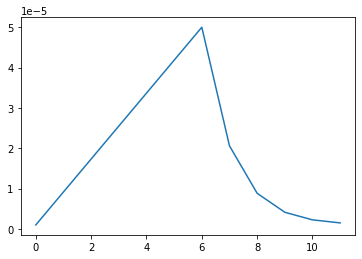

In [19]:
#带warm_up的余弦衰减
LR_START = 0.00000
LR_MAX = 0.00005 
LR_MIN = LR_START = 0.000001
LR_RAMPUP_EPOCHS = 6
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .4

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr


rng = [i for i in range(EPOCHS)]
y_s = [lrfn(x) for x in rng]
print(y_s)
plt.plot(rng, y_s)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y_s[0], max(y_s), y_s[-1]))
lr_warm_up = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

## Load model into the TPU

## Train Model

First, we train on the subset of the training set, which is completely in English.

#### FOLD 1
use pseudo




Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/12
34/34 [==============================] - 89s 3s/step - accuracy: 0.6973 - loss: 0.5743 - f1_score: 0.6963 - val_accuracy: 0.7453 - val_loss: 0.5344 - val_f1_score: 0.7415 - lr: 1.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 9.166666666666668e-06.
Epoch 2/12
34/34 [==============================] - 26s 775ms/step - accuracy: 0.8342 - loss: 0.3637 - f1_score: 0.8338 - val_accuracy: 0.8861 - val_loss: 0.3453 - val_f1_score: 0.8847 - lr: 9.1667e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 1.7333333333333336e-05.
Epoch 3/12
34/34 [==============================] - 26s 772ms/step - accuracy: 0.9588 - loss: 0.1358 - f1_score: 0.9587 - val_accuracy: 0.9679 - val_loss: 0.1197 - val_f1_score: 0.9679 - lr: 1.7333e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 2.5500000000000003e-05.
Epoch 4/12
34/34 [==============================] - 20s 591ms/step - a

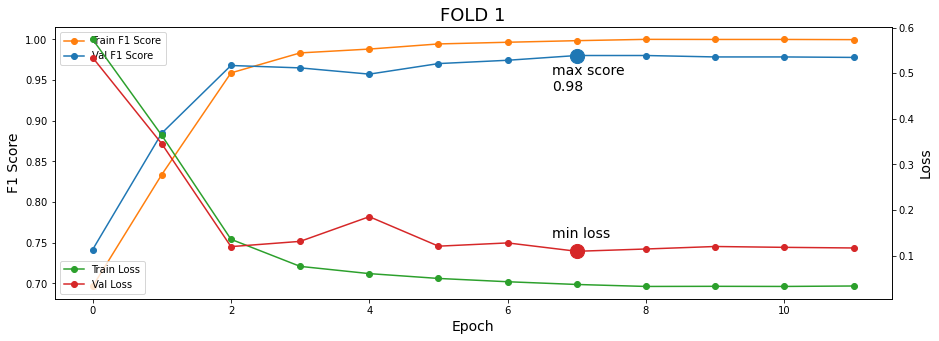

#### FOLD 2
use pseudo

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/12
34/34 [==============================] - 57s 2s/step - accuracy: 0.7043 - loss: 0.5761 - f1_score: 0.7039 - val_accuracy: 0.7634 - val_loss: 0.5450 - val_f1_score: 0.7621 - lr: 1.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 9.166666666666668e-06.
Epoch 2/12
34/34 [==============================] - 26s 770ms/step - accuracy: 0.8454 - loss: 0.3557 - f1_score: 0.8448 - val_accuracy: 0.9147 - val_loss: 0.2287 - val_f1_score: 0.9146 - lr: 9.1667e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 1.7333333333333336e-05.
Epoch 3/12
34/34 [==============================] - 27s 806ms/step - accuracy: 0.9521 - loss: 0.1447 - f1_score: 0.9521 - val_accuracy: 0.9620 - val_loss: 0.1322 - val_f1_score: 0.9620 - lr: 1.7333e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 2.5500000000000003e-05.
Epoch 4/12
34/34 [==============================

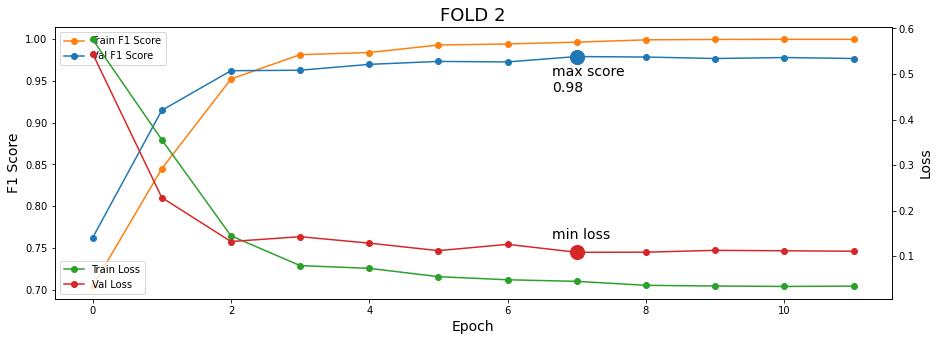

#### FOLD 3
use pseudo

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/12
34/34 [==============================] - 58s 2s/step - accuracy: 0.7174 - loss: 0.5498 - f1_score: 0.7138 - val_accuracy: 0.7447 - val_loss: 0.6001 - val_f1_score: 0.7443 - lr: 1.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 9.166666666666668e-06.
Epoch 2/12
34/34 [==============================] - 30s 875ms/step - accuracy: 0.8722 - loss: 0.3000 - f1_score: 0.8721 - val_accuracy: 0.9626 - val_loss: 0.1321 - val_f1_score: 0.9626 - lr: 9.1667e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 1.7333333333333336e-05.
Epoch 3/12
34/34 [==============================] - 28s 817ms/step - accuracy: 0.9728 - loss: 0.0991 - f1_score: 0.9728 - val_accuracy: 0.9772 - val_loss: 0.1044 - val_f1_score: 0.9772 - lr: 1.7333e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 2.5500000000000003e-05.
Epoch 4/12
34/34 [==============================

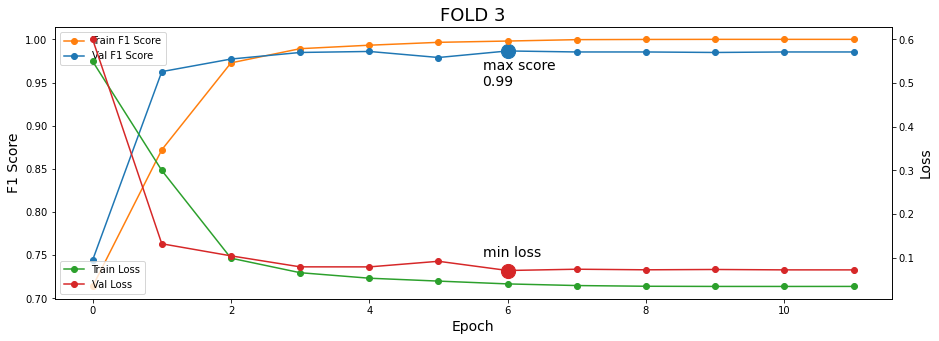

#### FOLD 4
use pseudo

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/12
34/34 [==============================] - 61s 2s/step - accuracy: 0.6742 - loss: 0.6134 - f1_score: 0.6740 - val_accuracy: 0.7091 - val_loss: 0.5917 - val_f1_score: 0.7087 - lr: 1.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 9.166666666666668e-06.
Epoch 2/12
34/34 [==============================] - 26s 770ms/step - accuracy: 0.8184 - loss: 0.4048 - f1_score: 0.8179 - val_accuracy: 0.8879 - val_loss: 0.2870 - val_f1_score: 0.8861 - lr: 9.1667e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 1.7333333333333336e-05.
Epoch 3/12
34/34 [==============================] - 26s 764ms/step - accuracy: 0.9519 - loss: 0.1528 - f1_score: 0.9519 - val_accuracy: 0.9650 - val_loss: 0.1233 - val_f1_score: 0.9649 - lr: 1.7333e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 2.5500000000000003e-05.
Epoch 4/12
34/34 [==============================

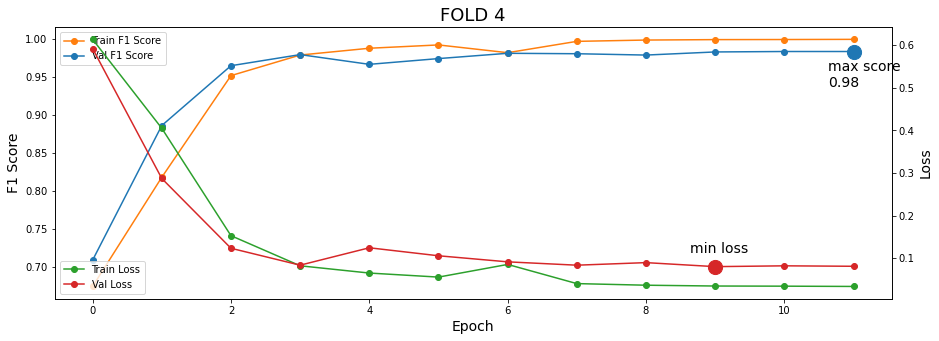

#### FOLD 5
use pseudo

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/12
34/34 [==============================] - 59s 2s/step - accuracy: 0.6807 - loss: 0.6211 - f1_score: 0.6806 - val_accuracy: 0.7085 - val_loss: 0.5326 - val_f1_score: 0.7084 - lr: 1.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 9.166666666666668e-06.
Epoch 2/12
34/34 [==============================] - 29s 853ms/step - accuracy: 0.8428 - loss: 0.3535 - f1_score: 0.8425 - val_accuracy: 0.9130 - val_loss: 0.2250 - val_f1_score: 0.9123 - lr: 9.1667e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 1.7333333333333336e-05.
Epoch 3/12
34/34 [==============================] - 27s 806ms/step - accuracy: 0.9492 - loss: 0.1556 - f1_score: 0.9492 - val_accuracy: 0.9650 - val_loss: 0.1112 - val_f1_score: 0.9650 - lr: 1.7333e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 2.5500000000000003e-05.
Epoch 4/12
34/34 [==============================

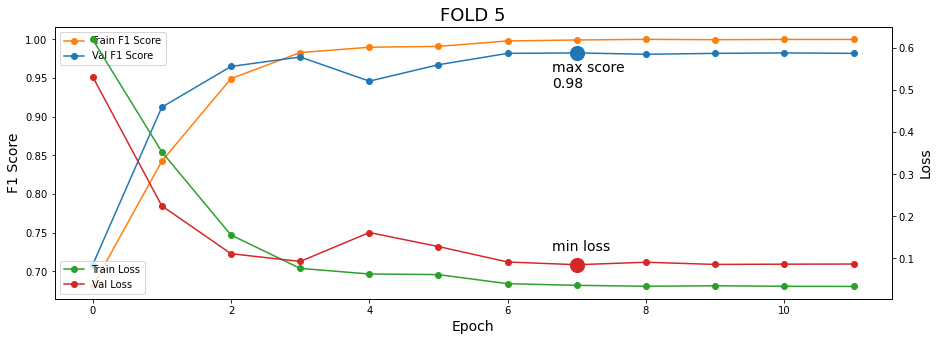

In [20]:
preds = []
weights = []
models = ["digitalepidemiologylab/covid-twitter-bert","distilroberta-base","nghuyong/ernie-2.0-en","lordtt13/COVID-SciBERT","digitalepidemiologylab/covid-twitter-bert-v2"]
for fold,(train,valid) in enumerate(kfold.split(fake_train1.tweet,fake_train1.label)):
    print('#### FOLD',fold+1)
    x_train,x_valid,y_train,y_valid = fake_train1.tweet[train],fake_train1.tweet[valid]\
    ,fake_train1.label[train],fake_train1.label[valid]
    if (use_pseudo):
        print("use pseudo")
        x_train = pd.concat([x_train, df_pseudo_cleaned.tweet]).reset_index(drop=True)
        y_train = pd.concat([y_train, df_pseudo_cleaned.label]).reset_index(drop=True)
    if (use_external2):
        x_train = pd.concat([x_train, fake_external2.tweet]).reset_index(drop=True)
        y_train = pd.concat([y_train, fake_external2.label]).reset_index(drop=True)
    
    tokenizer = AutoTokenizer.from_pretrained(models[0])
    
    x_fake_train = regular_encode(x_train,tokenizer, maxlen=MAX_LEN)
    x_fake_valid = regular_encode(x_valid,tokenizer,maxlen=MAX_LEN)

    y_fake_train = to_categorical(y_train,2,dtype='int32')
    y_fake_valid = to_categorical(y_valid,2,dtype='int32')
    
    train_dataset = get_train_dataset(x_fake_train,y_fake_train )
    valid_dataset = get_valid_dataset(x_fake_valid,y_fake_valid)
    
    n_steps = x_fake_train.shape[0] // BATCH_SIZE

    # BUILD MODEL
    K.clear_session()
    tf.tpu.experimental.initialize_tpu_system(tpu)
    with strategy.scope():
        transformer_layer = TFAutoModel.from_pretrained(models[0])
        model = build_model(transformer_layer, max_len=MAX_LEN)
        
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_f1_score', verbose=0, save_best_only=True,
        save_weights_only=True, mode='max', save_freq='epoch')
    cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_f1_score', factor = 0.1, patience = 2, verbose = 2, min_delta = 0.0001, mode = 'max')
    
    train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    callbacks = [cb_lr_schedule,sv,lr_warm_up],
    validation_data= valid_dataset,
    epochs=EPOCHS)
    
    
    print('Loading best model...')
    model.load_weights('fold-%i.h5'%fold)
    
        
    x_full_train = regular_encode(fake_train1.tweet, tokenizer, maxlen=MAX_LEN)
    
    
    weights.append(model.evaluate(valid_dataset)[2])
    x_fake_test = regular_encode(fake_test.tweet,tokenizer,maxlen=MAX_LEN)
    preds.append(model.predict(x_fake_test))
    
    
    if DISPLAY_PLOT:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(EPOCHS),train_history.history['f1_score'],'-o',label='Train F1 Score',color='#ff7f0e')
        plt.plot(np.arange(EPOCHS),train_history.history['val_f1_score'],'-o',label='Val F1 Score',color='#1f77b4')
        x = np.argmax( train_history.history['val_f1_score'] ); y = np.max( train_history.history['val_f1_score'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max score\n%.2f'%y,size=14)
        plt.ylabel('F1 Score',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(EPOCHS),train_history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(EPOCHS),train_history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( train_history.history['val_loss'] ); y = np.min( train_history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.title('FOLD %i'%(fold+1),size=18)
        plt.legend(loc=3)
        plt.show()  
        
    del model

In [21]:
def weight_ensemble(weights,predictions):
    weight_sum = np.sum(weights)  
    prediction_sum = 0
    for i in range(len(weights)):
        prediction_sum += (weights[i]/weight_sum)*predictions[i]
    print(prediction_sum)
    np.savez('model_predict_weight',prediction_sum)
    result = np.argmax(prediction_sum,axis=1)
    return result

In [22]:
def mean_ensemble(predictions):
    result = np.argmax(np.mean(predictions,axis=0),axis=1)
    np.savez('model_predict_mean',np.mean(predictions,axis=0))
    return result

In [23]:
weight_result= weight_ensemble(weights,preds)
# f1_score(np.array(fake_valid1.label,dtype='int32'),weight_result,average='weighted')

[[0.00455395 0.995446  ]
 [0.9961884  0.00381161]
 [0.9963539  0.00364614]
 ...
 [0.00249177 0.9975082 ]
 [0.00700169 0.99299824]
 [0.00305824 0.9969418 ]]


In [24]:
data1 = np.load('./model_predict_weight.npz')

In [25]:
# mean_result = mean_ensemble(preds)
# f1=f1_score(np.array(fake_valid1.label,dtype='int32'),mean_result,average='weighted')
# f1

In [26]:
# result = np.argmax(preds[4],axis=1)
# f1_score(np.array(fake_valid1.label,dtype='int32'),result,average='weighted')

In [27]:
def make_submission(result):
    submission = pd.DataFrame(columns=['id','label'])
    submission.label = result
    nlist = range(1,result.shape[0]+1)
    submission.id = nlist
    submission.to_csv('answer.txt', index=False)

In [28]:
make_submission(weight_result)
# make_submission(mean_result)

In [29]:
x

7

In [30]:
submission = pd.DataFrame(columns=['id','label'])
submission.label = weight_result
nlist = range(1,weight_result.shape[0]+1)
submission.id = nlist
submission.to_csv('answer.txt', index=False)

In [31]:

MODEL = "lordtt13/COVID-SciBERT"
tokenizer = AutoTokenizer.from_pretrained(MODEL)


x_fake_valid = regular_encode(fake_valid1.tweet,tokenizer,maxlen=MAX_LEN)
x_fake_train = regular_encode(fake_train1.tweet,tokenizer,maxlen=MAX_LEN)



y_fake_train = to_categorical(fake_train1.label,2,dtype='int32')
y_fake_valid = to_categorical(fake_valid1.label,2,dtype='int32')

with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()
n_steps = x_fake_train.shape[0] // BATCH_SIZE

train_dataset = get_train_dataset(x_fake_train,y_fake_train)
valid_dataset = get_valid_dataset(x_fake_valid,y_fake_valid)
cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_f1_score', factor = 0.5, patience = 3, verbose = 1, min_delta = 0.0001, mode = 'max')
sv = tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5', monitor='val_f1_score', verbose=0, save_best_only=True,
        save_weights_only=True, mode='max', save_freq='epoch')
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    callbacks = [cb_lr_schedule,lr_warm_up,sv],
    validation_data= valid_dataset,
    epochs=EPOCHS
    )
print('Loading best model...')
model.load_weights('best_model.h5')
x_fake_test = regular_encode(fake_valid1.tweet,tokenizer,maxlen=MAX_LEN)
score = model.evaluate(valid_dataset)[2]
pred = model.predict(x_fake_test)
np.savez('single-model',pred)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 140)]             0         
_________________________________________________________________
tf_bert_model_1 (TFBertModel ((None, 140, 768), (None, 110572032 
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 768)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1538      
Total params: 110,573,570
Trainable params: 110,573,570
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/12
33/33 [==============================] - 43s 1s/step - accuracy: 0.4659 - loss: 0.9567 - f1_score: 0.4629 - val_accuracy: 0.6603 - val_loss: 0.6227 - val_f1_score

In [32]:
f1_score(np.array(fake_valid1.label,dtype='int32'),np.argmax(pred,axis=1),average='weighted')

1.0

In [33]:
submission = pd.DataFrame(columns=['id','label'])
submission.label = result
nlist = range(1,result.shape[0]+1)
submission.id = nlist
submission.to_csv('answer.txt', sep='\t', index=False)

NameError: name 'result' is not defined